In [5]:
!pip install yfinance

In [7]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")



In [55]:
f = yf.download("GOOG",end="2021-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

[*********************100%***********************]  1 of 1 completed


In [57]:
mean = np.mean(return_serie)
vol = np.std(return_serie[return_serie<0])
sortino = np.sqrt(252) * mean/vol

print(f"Sortino : {'%.3f' % sortino}")

Sortino : 1.232


Index BETA

In [60]:
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

[*********************100%***********************]  1 of 1 completed


In [62]:
val = pd.concat((return_serie, sp500),axis = 1).dropna()
val

return     SP500
Date                          
2004-08-20  0.079430  0.006525
2004-08-23  0.010064 -0.002431
2004-08-24 -0.041408  0.000465
2004-08-25  0.010775  0.008000
2004-08-26  0.018019  0.000118
...              ...       ...
2020-12-24  0.003735  0.003537
2020-12-28  0.021416  0.008723
2020-12-29 -0.009780 -0.002227
2020-12-30 -0.010917  0.001342
2020-12-31  0.007105  0.006439

[4121 rows x 2 columns]

In [64]:
cov_var_mat = np.cov(val.values, rowvar = False)
cov_var_mat

array([[0.00037086, 0.00014733],
       [0.00014733, 0.00015267]])

In [70]:
# Calculem beta
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]
beta = cov/var
beta

0.9649854651878812

# Alpha

In [73]:
alpha = (252 * mean * (1-beta))*100
alpha

0.9240333142130545

# DrawDown

In [76]:
def drawdown_function(serie):
    cum = serie.dropna().cumsum() + 1
    runing_max = np.maximum.accumulate(cum)
    drawdown = cum / runing_max - 1
    return drawdown

In [78]:
drawdown = drawdown_function(return_serie)
drawdown

Date
2004-08-20    0.000000
2004-08-23    0.000000
2004-08-24   -0.038006
2004-08-25   -0.028116
2004-08-26   -0.011577
                ...   
2020-12-24   -0.009246
2020-12-28   -0.005249
2020-12-29   -0.007074
2020-12-30   -0.009112
2020-12-31   -0.007786
Name: return, Length: 4121, dtype: float64

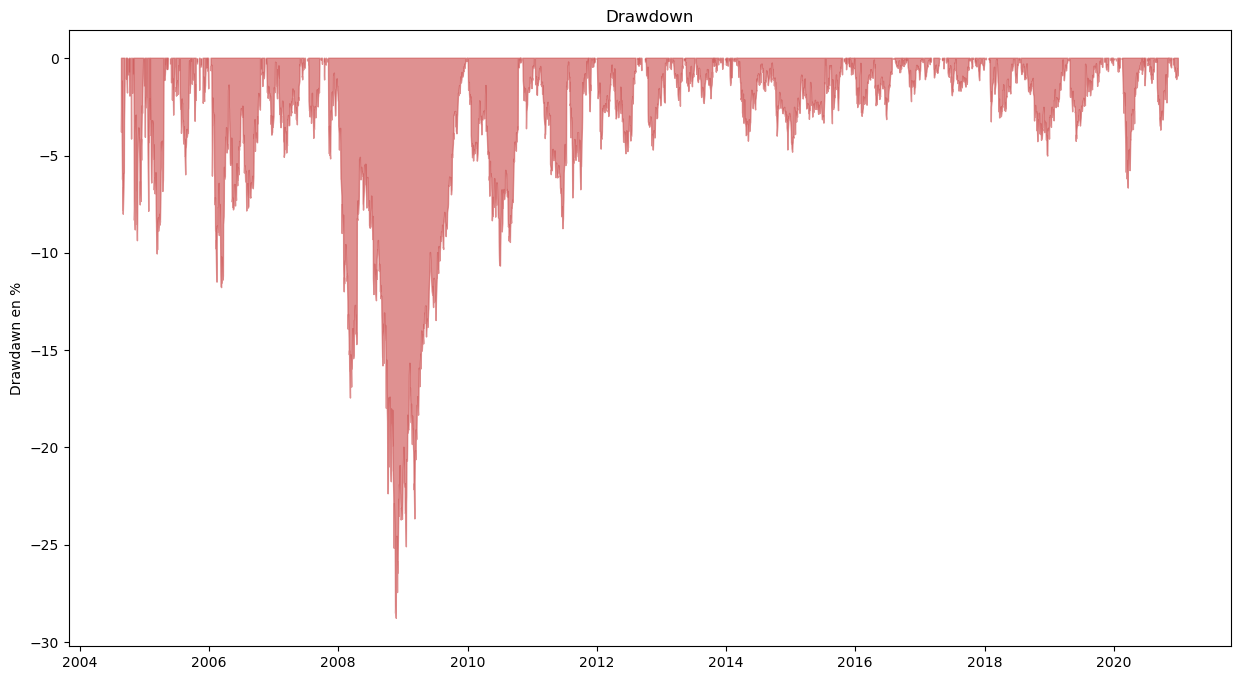

In [87]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,8))
plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, color = "#CE5757", alpha = 0.65)
plt.title("Drawdown")
plt.ylabel("Drawdawn en %")
plt.show()

In [93]:
max_drawdown = -np.min(drawdown)*100
print(f"Max Drawdown = {'%.3f' % max_drawdown}")

Max Drawdown = 28.780


# Back Testing


def BackTest(serie, annualized_scalar = 252):
    sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
    sp500.name = "SP500"
    val = pd.concat((return_serie, sp500),axis = 1).dropna()
    drawdown = drawdown_function(return_serie)
    max_drawdown = -np.min(drawdown)*100

    fig, (cum,dra) = plt.subplots(1,2,figsize=(20,6))
    fig.suptitle("Backtesting", size = 20)
    cum.plot(serie.cumsum()*100, color = "#39B3C7")
    cum.plot(val["SP500"].cumsum()*100, color = "#B85A0F")
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return ", size = 13)
    cum.set_ylabel("Cumulative Rerturn %", size = 11)
    plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, color = "#CE5757", alpha = 0.65)
    plt.title("Drawdown")
    plt.ylabel("Drawdawn en %")
    plt.show()
    sortino = np.sqrt(annualized_scalar)* serie.mean()/serie.loc[serie<0].std()
    beta = np.cov(val[["return","SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)
    alpha = (annualized_scalar * (serie.mean() - beta * serie.mean()))

    print(f"Sortino : {np.round(sortino,3)}")
    print(f"Beta : {np.round(beta,3)}")
    print(f"Alpha : {np.round(alpha,3)} %")
    print(f"MaxDrawdown : {np.round(max_drawdown,3)} %")



[*********************100%***********************]  1 of 1 completed


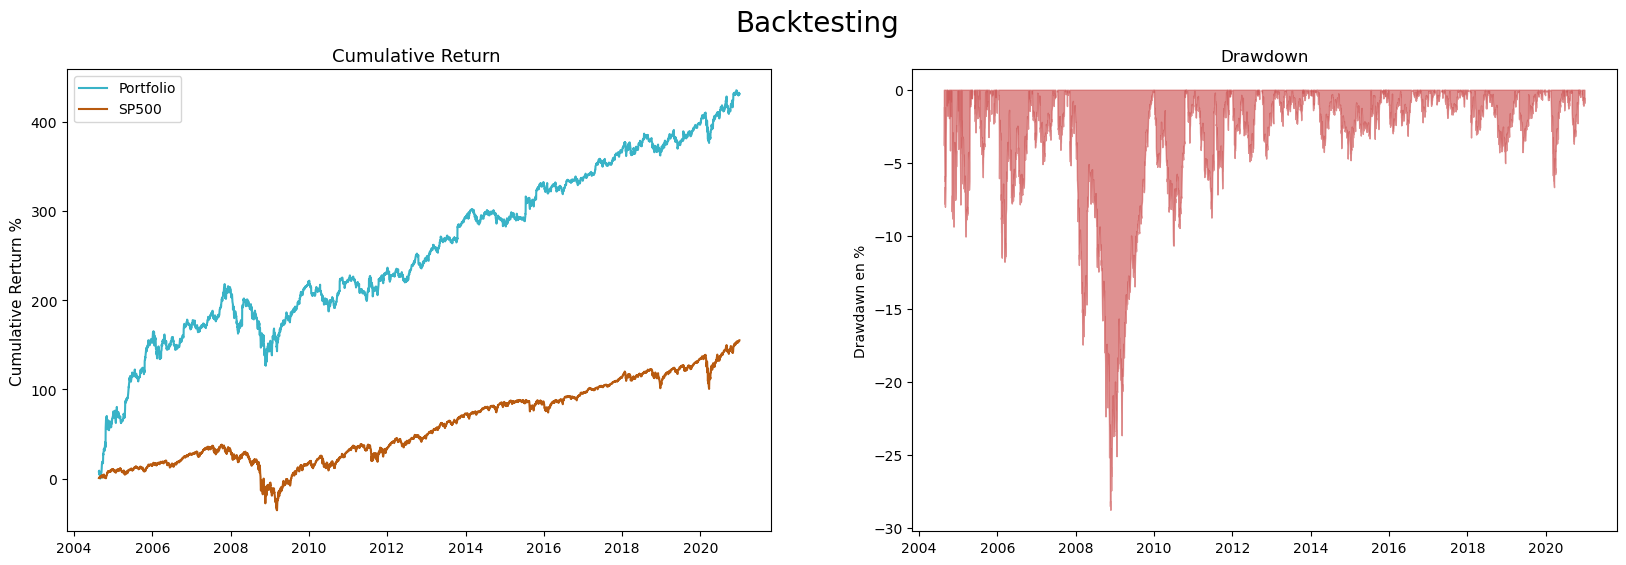

Sortino : 1.232
Beta : 0.965
Alpha : 0.009 %
MaxDrawdown : 28.78 %


In [109]:
BackTest(return_serie)

# Sección 1: Sortino Beta Alpha

Sortino
El índice de Sortino es una estadística similar al índice de Sharpe con la misma interpretación. Sin embargo, el cálculo es ligeramente diferente. En efecto, en el índice de Sortino sólo se tiene en cuenta la volatilidad de las ganancias negativas porque es lo que tememos y no las ganancias alcistas que nos hacen ganar diner

-  


SortinoRatio < 0 : Inversión no rentable porque las ganancias son neg
- tivas.
SortinoRatio < 1: Inversión rentable, pero el riesgo de la inversión es mayor que la renta
- ilidad.
SortinoRatio > 1: Inversión muy rentable porque el riesgo es menor que el ren


# Beta
La beta es un estadístico que indica la relación entre las variaciones de nuestra cartera y las del mercado que está representado por un índice (por ejemplo el SP500)

- 


abs(Beta) < 1: Es bueno porque significa que la cartera tiene una variación menor que el índice. (Si beta=0,9 significa que si el índice varía en 1 la cartera varía e
-  0,9)
abs(Beta) > 1: No es bueno porque significa que slau cartera tiene una variación mayor que el índice. (Si beta=1,1 significa que si el índice varía de 1 la cartera varía en 1,1)
abs(-x) = x = abs(x) (abs da sólo el valor de la variable no e

# Alpha

El alfa es una estadístico que indica si la cartera supera al mercado en términos de rentabilidad del riesgo
.


alfa > 0: La cartera supera al mercado en términos de rentabilidad del ri- esgo
alfa < 0: la cartera tiene un rendimiento inferior al del mercado en términos de riesgo-rendi


# Drawdown

El drawdown (reducción) es una medida del riesgo de la estrategia. Una estadística interesante para conocer el rendimiento del algoritmo es el drawdown máximo. En efecto, representa la pérdida máxima de una estrategia durante un período de tiempo que nos permite comprender si la estrategia es arriesgada y, por tanto, elegirla en función de nuestro nivel de aversión al riesgo.mientol signo)dimiento.